In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
df_training_data = np.load('/content/drive/MyDrive/ch2/training_data.npy')
df_categories = np.load('/content/drive/MyDrive/ch2/categories.npy')
df_valid_periods = np.load('/content/drive/MyDrive/ch2/valid_periods.npy')


(85570, 218)

In [9]:
def build_sequences(df, df_valid, df_categories, window=218, stride=70, telescope=18, min_samples_for_prediction=140):
    dataset = []
    categories = []

    # Funzionamento: prendo una serie e voglio far scorrere una finestra lunga window sulla serie che ogni volta scorre indietro di lunghezza stride
    # Quando sforo nella parte di zeri mi fermo e prendo degli zeri
    for i in range(df.shape[0]):
        row = df[i,df_valid[i,0]:df_valid[i,1]]
        idx = np.nonzero(row)[0][0]
        row = row[idx:]

        if row.shape[0]<min_samples_for_prediction :
            row = np.concatenate((np.zeros(window-row.shape[0],dtype='float32'),row))
            dataset.append(row)
            categories.append(df_categories[i])
        else:
            while row.shape[0]>=min_samples_for_prediction :
                if row.shape[0]>=window :
                    dataset.append(row[-window:])
                    categories.append(df_categories[i])
                else: #row.shape[0]<window
                    row_to_append = np.concatenate((np.zeros(window-row.shape[0],dtype='float32'),row))
                    dataset.append(row_to_append)
                    categories.append(df_categories[i])
                row = row[:-stride]

        # Il while non contempla il caso in cui da subito la serie sia più corta di 98, ed esco dal cico quando la parte rimanente della serie è più corta di 98
        # Ora gestisco questi casi: non faccio scorrere la finestra, faccio padding e appendo così com'è.
        # ATTENZIONE potrebbe capitare che il while mi restituisce una riga vuota percè è arrivato esattamente a 0, in quel caso non voglio fare padding e aggiungere zeri

    dataset = np.expand_dims(np.array(dataset),axis=-1)
    categories = np.expand_dims(np.array(categories),axis=-1)

    return dataset, categories

# BUILD DATASET
#dff, categories_letters = build_sequences(df_training_data, df_valid_periods, df_categories)
# con nuovo dataset nicco
dff = np.load('/content/drive/MyDrive/ch2/series_w218_h148_corr.npy')
dff = dff.reshape(85570, 218, 1)
categories_letters = np.load('/content/drive/MyDrive/ch2/cat_w218_h148_corr.npy')
categories_list = np.unique(categories_letters)
print(dff.shape, categories_letters.shape)

# TO_CATEGORICAL_HANDMADE
class_mapping = {
            'A': [1, 0, 0, 0, 0, 0],
            'B': [0, 1, 0, 0, 0, 0],
            'C': [0, 0, 1, 0, 0, 0],
            'D': [0, 0, 0, 1, 0, 0],
            'E': [0, 0, 0, 0, 1, 0],
            'F': [0, 0, 0, 0, 0, 1],
            }
categories_cat = []
for i in range(categories_letters.shape[0]):
  categories_cat.append(class_mapping.get(categories_letters[i][0], -1))
categories_cat = np.expand_dims(np.array(categories_cat), -1)
print(categories_cat.shape)

# DATA AUGMENTATION
X_train = dff[:, :-18]
y_train = dff[:, -18:]
X_train = np.concatenate((X_train, categories_cat), axis = 1)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.15, random_state=43)

@tf.function
def custom_augment(x, label):
    # Randomly apply transformation (color distortions) with probability p.
    x = random_apply(jitter, x, p=0.6)
    x, label = invert(x, label, pp = 0.05)
    return (x, label)

@tf.function
def jitter(x, s=0.04):
    # one can also shuffle the order of following augmentations
    # each time they are applied.
    cacca = tf.where(x!=0)[0][0]

    x_noise = x[cacca:-6, :]
    myNoise = tf.random.normal(stddev=s, shape=tf.shape(x_noise), dtype = tf.float64)
    x_noise = x_noise + myNoise
    x = tf.concat((x[:cacca, :], x_noise, x[-6:, :]), axis = 0)
    return x

@tf.function
def invert(x, label, pp = 0.3):
  if tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32) < pp:
    cacchina = len(label)

    cacca = tf.where(x!=0)[0][0]
    x_noise = x[cacca:-6, :]
    x_noise = tf.concat((x_noise, label), axis = 0)
    x_noise = x_noise[::-1]
    tr = x_noise[:-cacchina]
    label = x_noise[-cacchina:]
    x = tf.concat((x[:cacca, :], tr, x[-6:, :]), axis = 0)
  return x, label

@tf.function
def random_apply(func, x,  p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))#remove astype(int) at the end
validation_tf = tf.data.Dataset.from_tensor_slices((X_val,y_val))

BS = 512
AUTO = tf.data.experimental.AUTOTUNE

train_tf = (
    train_tf
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BS)
    .prefetch(AUTO)
)

validation_tf = (
    validation_tf
    .shuffle(100)
    .batch(BS)#BS
    .prefetch(AUTO)
)

(85570, 218, 1) (85570,)
(85570, 6, 1)


In [ ]:
#df = df.reshape(48000, 2776, 1)

In [ ]:
dff.shape[0]

94693

PLOT ONE OBSERVATION WITHOUT THE ZEROS

In [ ]:
#plt.plot(df[10330])
cacca=(np.where(nonzero_period[:, 0]>2776-70)[0])
print(len(cacca))
idx = cacca[111]
plt.plot(df[idx][nonzero_period[idx][0]:nonzero_period[idx][1]])
print(label_df[idx])
plt.show()

In [ ]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'activity', data = df, order = label_df)
plt.title('Activity Timestamps')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

LR_ASK

In [10]:
import time
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
class LR_ASK(tf.keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.75): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor

    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to'
            print(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print(msg)
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss
            pimprov=(deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print(msg) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print(msg) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights

        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print(msg) # cyan foreground
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print(msg) # cyan foreground

MODELLO INIZIALE VANILLA MOLTO STUPIDO

In [ ]:
df.shape

(48000, 2776, 1)

In [ ]:
X_train = df[:, :-18]
y_train = df[:, -18:]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=43)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 10

In [ ]:
input_shape

(2758, 1)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # add Masking
    x = tfkl.Masking(mask_value = 0, input_shape = input_shape)(input_layer)

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.LSTM(64, activation='tanh', return_sequences=True)(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2758, 1)]         0         
                                                                 
 masking (Masking)           (None, 2758, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 2758, 64)          16896     
                                                                 
 conv (Conv1D)               (None, 2758, 128)         24704     
                                                                 
 output_layer (Conv1D)       (None, 2758, 1)           385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                                 
Total params: 41985 (164.00 KB)
Trainable params: 4

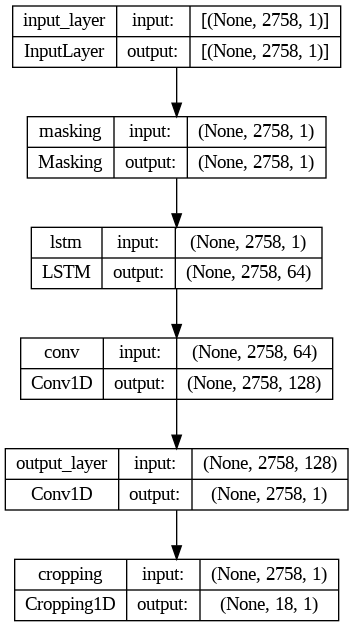

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 5,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True, verbose = 2),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/5


ValueError: ignored

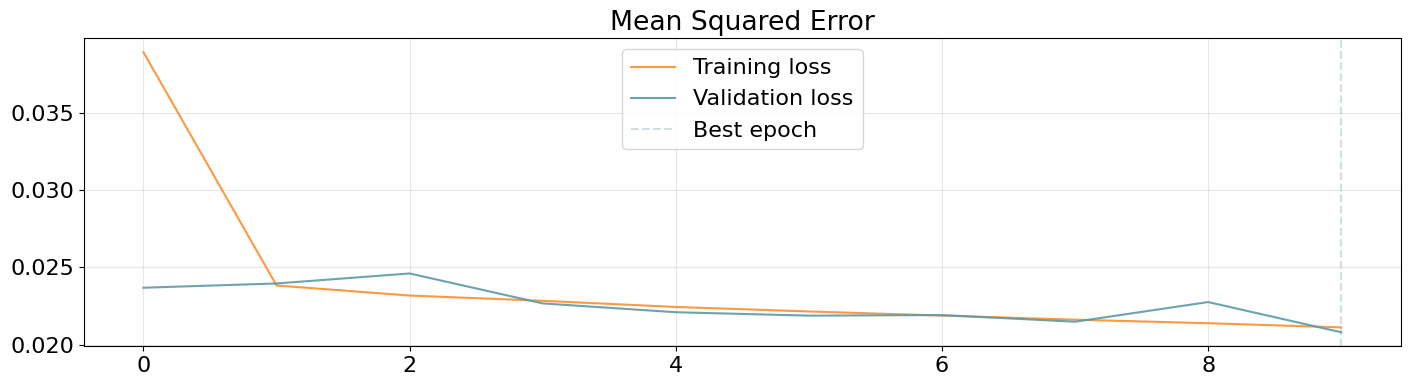

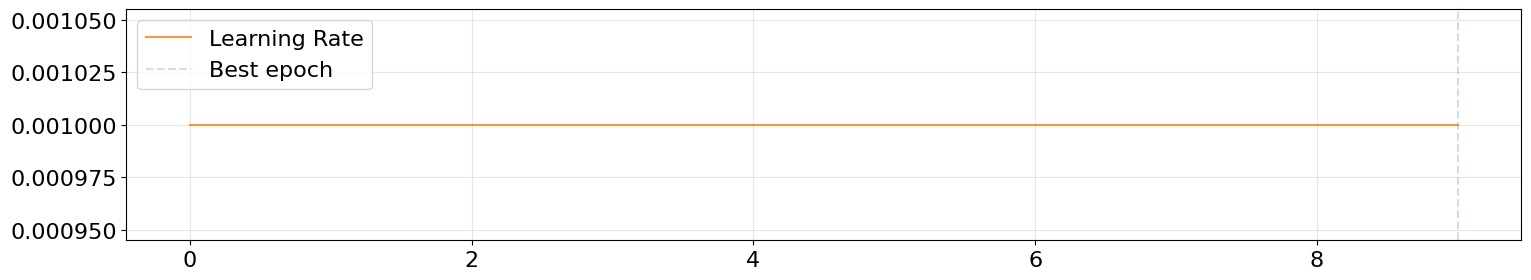

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/ch2/cacca1')

FAST FOURIER TRANSFORM FOR FREQUENCY HIGHLIGHT

MODELLO TENENDO CONTO DELLE CATEGORIE

AUGMENTATION

In [ ]:
@tf.function
def custom_augment(x, labels):
    # Randomly apply transformation (color distortions) with probability p.
    x = random_apply(jitter, x, p=0.4)
    return (x, labels)

@tf.function
def jitter(x, s=0.04):
     # one can also shuffle the order of following augmentations
    # each time they are applied.
    cacca = tf.where(x!=0)[0][0]
    x_noise = x[cacca:-6, :]
    myNoise = tf.random.normal(stddev=s, shape=tf.shape(x_noise), dtype = tf.float64)
    x_noise = x_noise + myNoise
    x = tf.concat((x[:cacca, :], x_noise, x[-6:, :]), axis = 0)
    return x
@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)


TensorShape([402, 1])

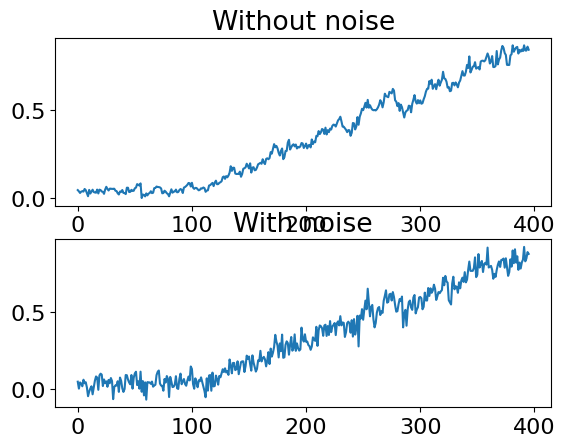

In [ ]:
x = X_train[0]
x_n = x[tf.where(x!=0)[0][0]:-6, :]
myNoise = tf.random.normal(stddev=0.04, shape=x_n.shape)
x_noise = x_n + myNoise
x_final = tf.concat((x_noise, x[-6:, :]), axis = 0)

figure, axis = plt.subplots(2, 1)

# For Sine Function
axis[0].plot(x_n)
axis[0].set_title("Without noise")

# For Cosine Function
axis[1].plot(x_noise)
axis[1].set_title("With noise")

x_final.shape

In [ ]:
print(x_final)

In [ ]:
#serie_size = df.shape[1]
from sklearn.model_selection import train_test_split
categories = categories.reshape(df.shape[0], 1)

categories = tf.keras.utils.to_categorical(np.asarray(pd.factorize(categories[:, 0])[0]), 6)
categories = categories.reshape(df.shape[0], 6, 1)

X_train = df[:, :-18]
y_train = df[:, -18:]
X_train = np.concatenate((X_train, categories), axis = 1)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.15, random_state=43)
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 10

In [ ]:
train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))#remove astype(int) at the end
validation_tf = tf.data.Dataset.from_tensor_slices((X_val,y_val))

BS = 128
AUTO = tf.data.experimental.AUTOTUNE

train_tf = (
    train_tf
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BS)
    .prefetch(AUTO)
)

validation_tf = (
    validation_tf
    .shuffle(100)
    .batch(BS)#BS
    .prefetch(AUTO)
)

In [ ]:
X_train.shape

(40800, 2764, 1)

In [ ]:
from tensorflow.keras import layers as tfkl

def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"


    # Define the input layer with the specified shape
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    input1 = tf.keras.layers.Lambda(lambda x: x[:, :-6])(input_layer)
    input2 = tf.keras.layers.Lambda(lambda x: x[:, -6:])(input_layer)
    input2 = tf.keras.layers.Reshape((6,))(input2)
    # encoded = tfkl.Embedding(6, 64)(input2)
    encoded = tfkl.Dense(256, activation = 'relu')(input2) # TUNE
    encoded = tfkl.Dense(128, activation = 'relu')(encoded) # TUNE

    x = tfkl.LSTM(64, input_shape = input_shape)(input1)
    x = tfkl.concatenate([x, encoded])

    x = tfkl.RepeatVector(500)(x)
    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.LSTM(128, return_sequences = True)(x)
    x = tfkl.Dropout(rate=.4, seed=123)(x)
    x = tfkl.LSTM(256, return_sequences = True)(x)

    x = tfkl.Conv1D(256, 3, padding='same', activation='relu', name='conv')(x)


    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # output_layer = tfkl.Dense(64, activation = 'relu')(output_layer)
    output_layer2 = tfkl.Dense(256, activation = 'relu')(input2)
    output_layer2 = tfkl.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(output_layer2)
    output_layer2 = tfkl.Dense(128, activation = 'relu')(output_layer2)
    output_layer2 = tfkl.Dropout(rate=.4, seed=123)(output_layer2)
    output_layer2 = tfkl.RepeatVector(500)(output_layer2)
    output_layer2 = tfkl.Dense(64, activation = 'tanh')(output_layer2)

    output_layer = tfkl.concatenate([output_layer, output_layer2])

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)
    output_layer = tfkl.GlobalAveragePooling1D(data_format='channels_first')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')


    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adamax())

    print(model.summary())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2758, 1)]         0         
                                                                 
 lambda_10 (Lambda)          (None, 2752, 1)           0         
                                                                 
 lstm_27 (LSTM)              (None, 64)                16896     
                                                                 
 repeat_vector_15 (RepeatVe  (None, 500, 64)           0         
 ctor)                                                           
                                                                 
 lstm_28 (LSTM)              (None, 500, 128)          98816     
                                                                 
 dropout_12 (Dropout)        (None, 500, 128)          0         
                                                   

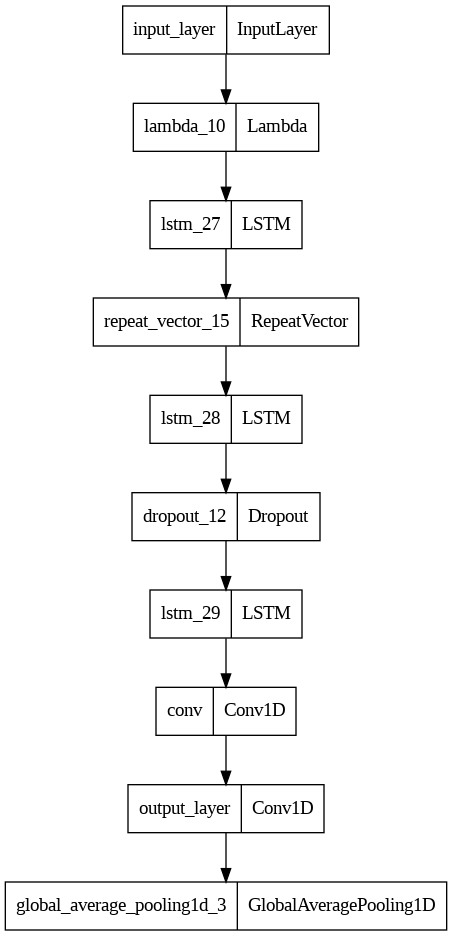

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
tfk.utils.plot_model(model)

In [ ]:
# Train the model
ask_epoch = 10
epochs = 50
ask=LR_ASK(model, epochs,  ask_epoch)
history=model.fit(x=train_tf, epochs=epochs, verbose=1, callbacks=[ask],  validation_data=validation_tf,
               validation_steps=None,  shuffle=False,  initial_epoch=0)


NameError: ignored

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/ch2/cacca5_noise')

In [ ]:
del model

SUA MAESTA: TRANSFORMER

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow.keras.layers as layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=1
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res


###############START MODEL############################

n_timesteps, n_features, n_outputs = 200, 1, 18
bigger = n_timesteps + 6

input_layer = tf.keras.Input(shape=(bigger, n_features), name='input_layer')
input1 = layers.Lambda(lambda x: x[:, :-6], output_shape=(n_timesteps, n_features))(input_layer)

##start CATEGORIES
input2 = layers.Lambda(lambda x: x[:, -6:])(input_layer)
input2 = layers.Reshape((6,))(input2)
output_layer2 = layers.Dense(512, activation = 'tanh')(input2)
output_layer2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(output_layer2)
output_layer2 = layers.Dense(256, activation = 'relu')(output_layer2)
output_layer2 = layers.Dense(64, activation = 'tanh')(output_layer2)
##end CATEGORIES

# start TRANSFORMER
x = transformer_encoder(input1, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
# end TRANSFORMER

#start LSTM
x = layers.LSTM(128, return_sequences = True)(x)
x = layers.Dropout(rate=.1, seed=123)(x)
x = layers.LSTM(128, return_sequences = True)(x)
#end LSTM

#start FINAL DENSE AND CONCAT
x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
for dim in [256, 128]:
  x = layers.Dense(dim, activation="tanh")(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = layers.Dense(64, activation = 'tanh')(x)

x = layers.concatenate([x, output_layer2])
output_layer = layers.Dense(18, activation = 'softmax')(x)
#end FINAL DENSE AND CONCAT

model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adamax(1e-2))

model.summary()

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 206, 1)]             0         []                            
                                                                                                  
 lambda_4 (Lambda)           (None, 200, 1)               0         ['input_layer[0][0]']         
                                                                                                  
 layer_normalization_8 (Lay  (None, 200, 1)               2         ['lambda_4[0][0]']            
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 200, 1)               3585      ['layer_normaliz

In [ ]:
# Train the model
ask_epoch = 10
epochs = 50
ask=LR_ASK(model, epochs,  ask_epoch)
history=model.fit(x=train_tf, epochs=epochs, verbose=1, callbacks=[ask],  validation_data=validation_tf,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

LINFORMER FOR REDUCING COMPUTATIONAL COMPLEXITY

In [15]:
def get_EF(input_size, dim, method="learnable", head_dim=None, bias=True):
    """
    Retuns the E or F matrix, initialized via xavier initialization.
    This is the recommended way to do it according to the authors of the paper.
    Includes a method for convolution, as well as a method for no additional params.
    """
    assert method == "learnable" or method == "convolution" or method == "no_params", "The method flag needs to be either 'learnable', 'convolution', or 'no_params'!"
    if method == "convolution":
        conv = tf.keras.layers.Conv1D(head_dim, head_dim, kernel_size=int(input_size/dim), stride=int(input_size/dim))
        return conv
    if method == "no_params":
        mat = tf.zeros((input_size, dim))
        tf.random.normal(mat, mean=0.0, stddev=1/dim)
        return mat
    lin = tf.keras.layers.Dense(dim, use_bias=bias)
    tf.keras.initializers.GlorotNormal(lin.weights)
    return lin


In [14]:
class LinearAttentionHead(tf.keras.layers.Layer):
    """
    Linear attention, as proposed by the linformer paper
    """
    def __init__(self, dim, dropout, E_proj, F_proj, causal_mask, full_attention=False):
        super(LinearAttentionHead, self).__init__()
        """
        full_attention if true means original transformer with O(n^2) time and space complexity
        """
        self.E = E_proj
        self.F = F_proj
        self.dim = dim
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.P_bar = None
        self.full_attention = full_attention
        self.causal_mask = causal_mask
        self.is_proj_tensor = tf.is_tensor(E_proj)

    def call(self, Q, K, V, **kwargs):
        """
        Q: Q * W_q
        K: K * W_k
        V: V * W_v
        """
        input_mask = kwargs["input_mask"] if "input_mask" in kwargs else None
        embeddings_mask = kwargs["embeddings_mask"] if "embeddings_mask" in kwargs else None

        # masking for K, V
        if input_mask is not None:
            mask = input_mask[:,:,None]
            zero_mat = tf.zeros((mask.shape))
            K = tf.where(mask==False, zero_mat, K)
            V = tf.where(mask==False, zero_mat, V)
            del zero_mat
            del mask

        # masking for Q
        if embeddings_mask is not None:
            mask = embeddings_mask[:,:,None]
            zero_mat = tf.zeros((mask.shape))
            Q = tf.where(mask==False, zero_mat, Q)
            del zero_mat
            del mask

        # compute E * K * W_k if needed
        K = tf.transpose(K, perm=[0, 2, 1])
        if not self.full_attention:
            # use implementation of the paper
            if self.is_proj_tensor:
                K = tf.matmul(K, self.E)
            else:
                K = self.E(K)

        Q = tf.matmul(Q, K)

        P_bar = Q/tf.math.sqrt(float(self.dim))
        if self.causal_mask is not None:
            inf_mat = tf.cast(tf.convert_to_tensor(np.ones((self.causal_mask.shape))*np.NINF), tf.float32)
            P_bar = tf.where(self.causal_mask==False, inf_mat, P_bar)
        P_bar = tf.nn.softmax(P_bar, axis=2)

        P_bar = self.dropout(P_bar)

        # compute F * V * W_v if needed
        if not self.full_attention:
            V = tf.transpose(V, perm=[0, 2, 1])
            if self.is_proj_tensor:
                V = tf.matmul(V, self.F)
            else:
                V = self.F(V)
            V = tf.transpose(V, perm=[0, 2, 1])

        linear_head = tf.matmul(P_bar, V)

        return linear_head

In [18]:
class MHAttention(tf.keras.layers.Layer):
    """
    (1) generate K Q V dense layer as W_k, W_q, W_v to be used in single head attention computation
    (2) apply a tranformation layer to cascade all heads to get the output
    """
    def __init__(self, input_size, dim, channels, dim_k, nhead, dropout, parameter_sharing,
        E_proj, F_proj, full_attention, causal_mask, w_o_intermediate_dim=None, decoder_mode=False, method="learnable"):
        super(MHAttention, self).__init__()
        self.heads = [] # a list of head
        self.input_size = input_size # window_size for encoder & decoder (# of words in each batch)
        self.dim_k = dim_k # main idea of paper
        self.channels = channels # size of a word vector (before embedding)
        self.causal_mask = causal_mask
        self.w_o_intermediate_dim = w_o_intermediate_dim
        if parameter_sharing != "layerwise":
            E_proj = get_EF(input_size, dim_k, method, dim)
            F_proj = get_EF(input_size, dim_k, method, dim) if parameter_sharing == "none" or parameter_sharing == "headwise" else E_proj

        self.decoder_mode = decoder_mode
        self.to_q = []
        self.to_k = []
        self.to_v = []

        for _ in range(nhead):
            if parameter_sharing == "none":
                E_proj = get_EF(input_size, dim_k, method, dim)
                F_proj = get_EF(input_size, dim_k, method, dim)
            attn = LinearAttentionHead(dim, dropout, E_proj, F_proj, causal_mask, full_attention)
            self.heads.append(attn)
            self.to_q.append(tf.keras.layers.Dense(dim, use_bias=False))
            self.to_k.append(tf.keras.layers.Dense(dim, use_bias=False))
            self.to_v.append(tf.keras.layers.Dense(dim, use_bias=False))
        if w_o_intermediate_dim is None:
            self.w_o = tf.keras.layers.Dense(channels)
        else:
            self.w_o_1 = tf.keras.layers.Dense(w_o_intermediate_dim)
            self.w_o_2 = tf.keras.layers.Dense(channels)
        self.mh_dropout = tf.keras.layers.Dropout(dropout)

    def call(self, tensor, **kwargs):
        batch_size, input_len, channels = tensor.shape
        assert not (self.decoder_mode and "embeddings" not in kwargs), "Embeddings must be supplied if decoding"
        assert not ("embeddings" in kwargs and (kwargs["embeddings"].shape[0], kwargs["embeddings"].shape[1], kwargs["embeddings"].shape[2]) != (batch_size, input_len, channels)), "Embeddings size must be the same as the input tensor"
        head_outputs = []

        for index, head in enumerate(self.heads):
            Q = self.to_q[index](tensor)
            K = self.to_k[index](tensor) if not self.decoder_mode else self.to_k[index](kwargs["embeddings"])
            V = self.to_v[index](tensor) if not self.decoder_mode else self.to_v[index](kwargs["embeddings"])
            head_outputs.append(head(Q,K,V,**kwargs))

        # concat all head to one macro head
        out = tf.concat(head_outputs, axis=-1)
        if self.w_o_intermediate_dim is None:
            out = self.w_o(out)
        else:
            out = self.w_o_1(out)
            out = self.w_o_2(out)
        out = self.mh_dropout(out)
        return out

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow.keras.layers as layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  #x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=1)(x, x)
  # metto input_size = 218 che è il numero delle osservazioni
  # channels = 128 è la size della mlp
  x  = MHAttention(input_size = 218, dim = head_size, channels = 128, dim_k = 32, nhead = num_heads, dropout = dropout, parameter_sharing = "none",
        E_proj = [], F_proj = [], full_attention = False, causal_mask = None)(x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="tanh")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res


###############START MODEL############################

n_timesteps, n_features, n_outputs = 200, 1, 18
bigger = n_timesteps + 6

input_layer = tf.keras.Input(shape=(bigger, n_features), name='input_layer')
input1 = layers.Lambda(lambda x: x[:, :-6], output_shape=(n_timesteps, n_features))(input_layer)

##start CATEGORIES
input2 = layers.Lambda(lambda x: x[:, -6:])(input_layer)
input2 = layers.Reshape((6,))(input2)
output_layer2 = layers.Dense(256, activation = 'tanh')(input2)
output_layer2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(output_layer2)
output_layer2 = layers.Dense(64, activation = 'tanh')(output_layer2)
##end CATEGORIES

# start TRANSFORMER
x = transformer_encoder(input1, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)

# end TRANSFORMER

#start LSTM
x = layers.LSTM(128, return_sequences = True)(x)
x = layers.Dropout(rate=.1, seed=123)(x)
x = layers.LSTM(128, return_sequences = True)(x)
#end LSTM

#start FINAL DENSE AND CONCAT
x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
for dim in [128]:
  x = layers.Dense(dim, activation="leaky_relu")(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = layers.Dense(64, activation = 'tanh')(x)

x = layers.concatenate([x, output_layer2])
output_layer = layers.Dense(n_outputs, activation = 'sigmoid')(x)
#end FINAL DENSE AND CONCAT

model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adamax(1e-2))

model.summary()

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 206, 1)]             0         []                            
                                                                                                  
 lambda_12 (Lambda)          (None, 200, 1)               0         ['input_layer[0][0]']         
                                                                                                  
 layer_normalization_17 (La  (None, 200, 1)               2         ['lambda_12[0][0]']           
 yerNormalization)                                                                                
                                                                                                  
 mh_attention_6 (MHAttentio  (None, 200, 128)             118656    ['layer_normaliz

In [ ]:
# Train the model
ask_epoch = 10
epochs = 50
ask=LR_ASK(model, epochs,  ask_epoch)
history=model.fit(x=train_tf, epochs=epochs, verbose=1, callbacks=[ask],  validation_data=validation_tf,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training (0, 255, 0)
Epoch 1/50
142/143 [============================>.] - ETA: 0s - loss: 0.0277
 validation loss of  0.0587 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights
143/143 [==============================] - 37s 187ms/step - loss: 0.0277 - val_loss: 0.0587
Epoch 2/50
142/143 [============================>.] - ETA: 0s - loss: 0.0165
 validation loss of  0.0462 is 21.3067 % below lowest loss, saving weights from epoch 2   as best weights
143/143 [==============================] - 25s 174ms/step - loss: 0.0165 - val_loss: 0.0462
Epoch 3/50
  7/143 [>.............................] - ETA: 22s - loss: 0.0167

In [ ]:
model.save('/content/drive/MyDrive/ch2/linfomane')

In [ ]:
del model

LINFORMER + GTAED RESIDUAL

In [12]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)


In [13]:
class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate):
        super().__init__()
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x


In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow.keras.layers as layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  #x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=1)(x, x)
  # metto input_size = 218 che è il numero delle osservazioni
  # channels = 128 è la size della mlp
  x  = MHAttention(input_size = 218, dim = head_size, channels = 128, dim_k = 32, nhead = num_heads, dropout = dropout, parameter_sharing = "none",
        E_proj = [], F_proj = [], full_attention = False, causal_mask = None)(x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="tanh")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res


###############START MODEL############################

n_timesteps, n_features, n_outputs = 200, 1, 18
bigger = n_timesteps + 6

input_layer = tf.keras.Input(shape=(bigger, n_features), name='input_layer')
input1 = layers.Lambda(lambda x: x[:, :-6], output_shape=(n_timesteps, n_features))(input_layer)

##start CATEGORIES
input2 = layers.Lambda(lambda x: x[:, -6:])(input_layer)
input2 = layers.Reshape((6,))(input2)
output_layer2 = layers.Dense(256, activation = 'tanh')(input2)
output_layer2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(output_layer2)
output_layer2 = layers.Dense(64, activation = 'tanh')(output_layer2)
##end CATEGORIES

# start TRANSFORMER
x = transformer_encoder(input1, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)

# end TRANSFORMER

#start LSTM
x = layers.LSTM(128, return_sequences = True)(x)
x = layers.Dropout(rate=.1, seed=123)(x)
x = layers.LSTM(128, return_sequences = True)(x)
#end LSTM

#start FINAL DENSE AND CONCAT
x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
for dim in [128]:
  x = layers.Dense(dim, activation="leaky_relu")(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x =  GatedResidualNetwork(units = 64, dropout_rate = 0.1)(x)

x = layers.concatenate([x, output_layer2])
output_layer = layers.Dense(n_outputs, activation = 'sigmoid')(x)
#end FINAL DENSE AND CONCAT

model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adamax(1e-2))

model.summary()

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 206, 1)]             0         []                            
                                                                                                  
 lambda_10 (Lambda)          (None, 200, 1)               0         ['input_layer[0][0]']         
                                                                                                  
 layer_normalization_14 (La  (None, 200, 1)               2         ['lambda_10[0][0]']           
 yerNormalization)                                                                                
                                                                                                  
 mh_attention_5 (MHAttentio  (None, 200, 128)             118656    ['layer_normaliz

In [27]:
# Train the model
ask_epoch = 10
epochs = 50
ask=LR_ASK(model, epochs,  ask_epoch)
history=model.fit(x=train_tf, epochs=epochs, verbose=1, callbacks=[ask],  validation_data=validation_tf,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training (0, 255, 0)
Epoch 1/50
142/143 [============================>.] - ETA: 0s - loss: 0.0512
 validation loss of  0.0747 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights
143/143 [==============================] - 39s 189ms/step - loss: 0.0512 - val_loss: 0.0747
Epoch 2/50
142/143 [============================>.] - ETA: 0s - loss: 0.0216
 validation loss of  0.0469 is 37.2714 % below lowest loss, saving weights from epoch 2   as best weights
143/143 [==============================] - 25s 174ms/step - loss: 0.0216 - val_loss: 0.0469
Epoch 3/50
 60/143 [===========>..................] - ETA: 13s - loss: 0.0195

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/ch2/linf_grn')

In [ ]:
del model

GRU

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
import tensorflow.keras.layers as layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  #x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=1)(x, x)
  # metto input_size = 218 che è il numero delle osservazioni
  # channels = 128 è la size della mlp
  x  = MHAttention(input_size = 218, dim = head_size, channels = 128, dim_k = 32, nhead = num_heads, dropout = dropout, parameter_sharing = "none",
        E_proj = [], F_proj = [], full_attention = False, causal_mask = None)(x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="tanh")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res


###############START MODEL############################

n_timesteps, n_features, n_outputs = 200, 1, 18
bigger = n_timesteps + 6

input_layer = tf.keras.Input(shape=(bigger, n_features), name='input_layer')
input1 = layers.Lambda(lambda x: x[:, :-6], output_shape=(n_timesteps, n_features))(input_layer)

##start CATEGORIES
input2 = layers.Lambda(lambda x: x[:, -6:])(input_layer)
input2 = layers.Reshape((6,))(input2)
output_layer2 = layers.Dense(256, activation = 'leaky_relu')(input2)
output_layer2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(output_layer2)
output_layer2 = layers.Dense(64, activation = 'leaky_relu')(output_layer2)
##end CATEGORIES

# start TRANSFORMER
x = transformer_encoder(input1, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)
#x = transformer_encoder(x, head_size = 128, num_heads = 4, ff_dim = 2, dropout = 0.01)

# end TRANSFORMER

#start LSTM
x = layers.GRU(128, return_sequences = True)(x)
x = layers.Dropout(rate=.1, seed=123)(x)
x = layers.GRU(256, return_sequences = True)(x)
#end LSTM

#start FINAL DENSE AND CONCAT
x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
for dim in [256, 128]:
  x = layers.Dense(dim, activation="leaky_relu")(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
#x =  GatedResidualNetwork(units = 64, dropout_rate = 0.1)(x)
x = layers.Dense(64, activation = 'tanh')(x)

x = layers.concatenate([x, output_layer2])
output_layer = layers.Dense(n_outputs, activation = 'sigmoid')(x)
#end FINAL DENSE AND CONCAT

model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adamax(1e-2))

model.summary()

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 206, 1)]             0         []                            
                                                                                                  
 lambda_8 (Lambda)           (None, 200, 1)               0         ['input_layer[0][0]']         
                                                                                                  
 layer_normalization_12 (La  (None, 200, 1)               2         ['lambda_8[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 mh_attention_4 (MHAttentio  (None, 200, 128)             118656    ['layer_normaliz

In [25]:
# Train the model
ask_epoch = 10
epochs = 50
ask=LR_ASK(model, epochs,  ask_epoch)
history=model.fit(x=train_tf, epochs=epochs, verbose=1, callbacks=[ask],  validation_data=validation_tf,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training (0, 255, 0)
Epoch 1/50
142/143 [============================>.] - ETA: 0s - loss: 0.0304
 validation loss of  0.0196 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights
143/143 [==============================] - 44s 223ms/step - loss: 0.0304 - val_loss: 0.0196
Epoch 2/50
142/143 [============================>.] - ETA: 0s - loss: 0.0171
 validation loss of  0.0171 is 12.6547 % below lowest loss, saving weights from epoch 2   as best weights
143/143 [==============================] - 30s 210ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 3/50
142/143 [============================>.] - ETA: 0s - loss: 0.0162
 validation loss of  0.0149 is 12.7545 % below lowest loss, saving weights from epoch 3   as best weights
143/143 [=========================

In [ ]:
model.save('/content/drive/MyDrive/ch2/linf_gru')

In [ ]:
del model

ENSEMBLE

In [ ]:
grn = tfk.models.load_model('/content/drive/MyDrive/ch2/linf_grn')
gru = tfk.models.load_model('/content/drive/MyDrive/ch2/lintransf_lim150')

In [ ]:


from tensorflow.keras.layers import Layer, Concatenate
def weight_init(shape =(bigger, n_features), weights=[1, 1], dtype=tf.float32): #convnest_small has more weight (found to give better results)
    return tf.constant(np.array(weights).reshape(shape), dtype=dtype)

class WeightedAverage(Layer):

    def __init__(self):
        super(WeightedAverage, self).__init__()

    def build(self, input_shape):

        self.W = self.add_weight(
                    shape=(1,1,len(input_shape)),
                    initializer=weight_init,
                    dtype=tf.float32,
                    trainable=True, name = 'cacca')
    def call(self, inputs):

        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs)
        weights = tf.nn.softmax(self.W, axis=-1)

        return tf.reduce_mean(weights*inputs, axis=-1)



In [ ]:
gru._name = 'PD'

In [ ]:
from tensorflow.keras.layers import Layer, Concatenate
from tensorflow.keras.layers import Average
models = [grn, gru]

inputs = tfk.Input(shape=(bigger, n_features))
outputs = [model(inputs) for model in models]
outputs_ensemble = Average()(outputs)
model_ensemble = tfk.Model(inputs=inputs, outputs=outputs_ensemble, name='ensemble_base_large')

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adamax(1e-2))


In [ ]:
model.save('/content/drive/MyDrive/ch2/ensemble_gru_grn')
